##  Machine Learning Portfoilio for Predict House Value in California

In this session, we use chapter 2 of [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems by Aurélien Géron ](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow-ebook/dp/B07XGF2G87/)

In this chapter, you will go through <font color='blue'> **an example project end to end** </font>, **pretending** to be a recently hired **data scientist** in a real **estate company**.

**Look at the Big Picture**

<font color='red'> The project aim </font>:

- build a model of housing prices in California using the California census data (data is from 1990 census!)

<font color='red'> The data contains </font>:
- the population, median income, median housing price, and so on for each block group in California
- The block group?:
  - Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts





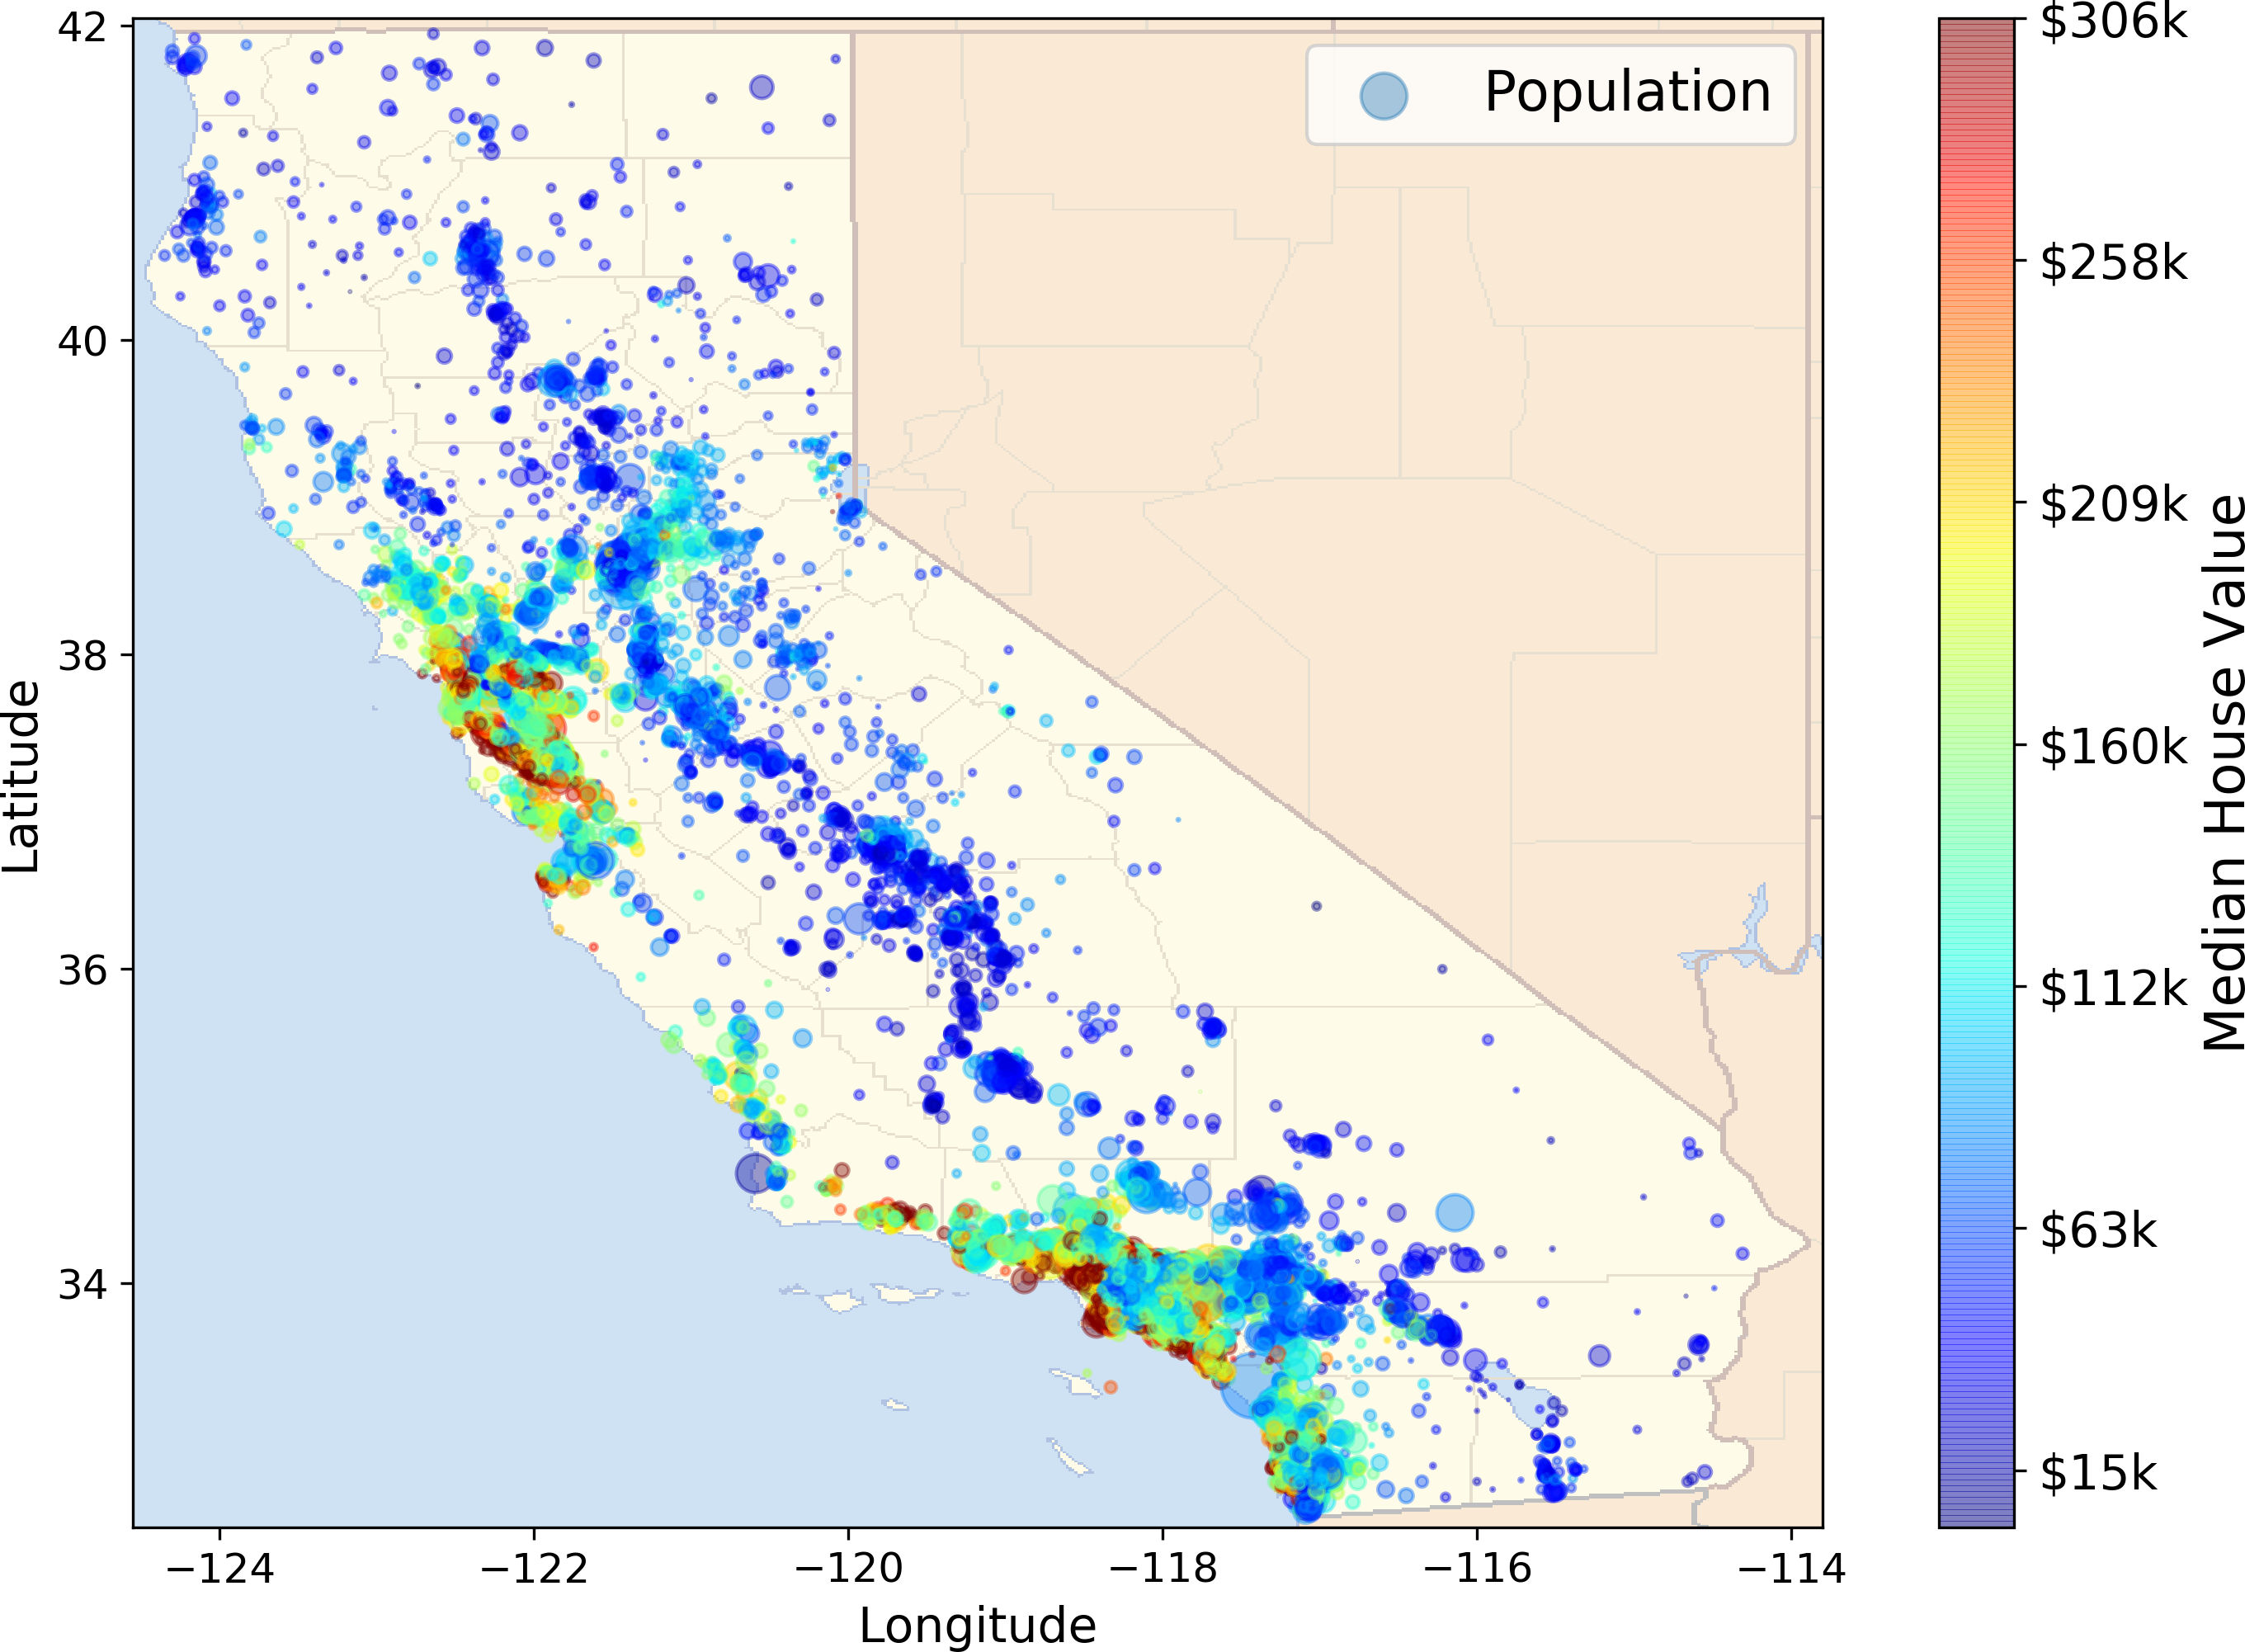

**Frame the Problem**

- Is it supervised, unsupervised, or Reinforcement
  Learning? 
- Is it a classification task, a regression task, or something else?

<font color='blue'> Answers: </font>

- it is clearly a typical <font color='green'> supervised </font> learning task since you are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price). 

- it is also a typical <font color='green'> regression </font> task , since you are asked to predict a value. 

- this is a <font color='blue'> multiple regression problem </font> since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.). 

- It is also a <font color='blue'> univariate regression problem </font> since we are only trying to predict a single value for each district. (If we were trying to predict multiple values per district, it would be a <font color='blue'> multivariate regression problem </font>.)

**Select a Performance Measure**

A typical performance measure for
regression problems is the Root Mean Square Error (RMSE):

$$\operatorname{RMSE}(\mathbf{X}, h)=\sqrt{\frac{1}{m} \sum_{i=1}^{m}\left(h\left(\mathbf{x}^{(i)}\right)-y^{(i)}\right)^{2}}$$


- $m$ is the number of instances in the dataset you are measuring the  RMSE on.

- $\mathbf{x}^{(i)}$ is a vector of all the feature values (excluding the label) of the $i^{th}$ instance in the dataset, and ${y}^{(i)}$ is its label (the desired output value for that instance).
 
- $\operatorname{RMSE}(\mathbf{X}, h)$ is the <font color='blue'> **cost function** </font> measured on the set of examples using your hypothesis $h$.


The other Performance Measures:

- Mean Absolute Error (MAE):

$$\operatorname{MAE}(\mathbf{X}, h)=\frac{1}{m} \sum_{i=1}^{m}\left|h\left(\mathbf{x}^{(i)}\right)-y^{(i)}\right|$$

<center>(it is usefull when there are many outlier districts)</center>

Various distance measures, or norms, are possible:

- Computing the root of a sum of squares (RMSE) corresponds to the *Euclidean norm*:  It is also called the $\ell_{2}$ *norm*, noted $\|\cdot\|_{2}$ (or just $\|\cdot\|$).

- Computing the sum of absolutes (MAE) corresponds to the $\ell_{1}$ *norm*, noted $\|\cdot\|_{1}$. It is sometimes called the <font color='blue'> *Manhattan norm* </font> because it measures the distance between two points in a city if you can only travel along orthogonal city blocks.

- More generally, the $\ell_{k}$ *norm* of a vector $\mathbf{v}$ containing $n$ elements is defined as:
$$\|\mathbf{v}\|_{k}=\left(\left|v_{0}\right|^{k}+\left|v_{1}\right|^{k}+\cdots+\left|v_{n}\right|^{k}\right)^{\frac{1}{k}}$$
<center> $\ell_{0}$ just gives the number of non-zero elements
in the vector, and $\ell_{\infty}$ gives the maximum absolute value in the vector.</center>

- The higher the norm index, the more it focuses on large values and neglects small ones. This is why the RMSE is more sensitive to outliers than the MAE. But when outliers are exponentially rare (like in a bell-shaped curve), the RMSE performs very well and is generally preferred.

**Get the Data**

You can download the data (housing.csv) from:

https://github.com/ageron/handson-ml2/tree/master/datasets/housing

In [1]:
import pandas as pd
housing=pd.read_csv("housing.csv")
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

The   **`info()`** method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- Notice that the `total_bedrooms` attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later.

- All attributes are numerical, except the `ocean_proximity` field. Its type is object, so it could hold any kind of Python object, but since you loaded this data from a CSV file you know that it must be a text attribute. When you looked at the top five rows, you
probably noticed that the values in the `ocean_proximity` column were <font color='red'> repetitive</font>, which means that it is probably a <font color='red'> categorical attribute </font>. You can find out what categories exist and how many districts belong to each category by using the **`value_counts()`** method:

In [3]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The **describe()** method shows a summary of the
numerical attributes:

In [4]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

**histogram** : graph to show frequency distributions

You can either plot this one attribute at a time, or you can call the `hist()` method on the whole dataset, and it will plot a histogram for each numerical attribute:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb21aa23ef0>,
      dtype=object)

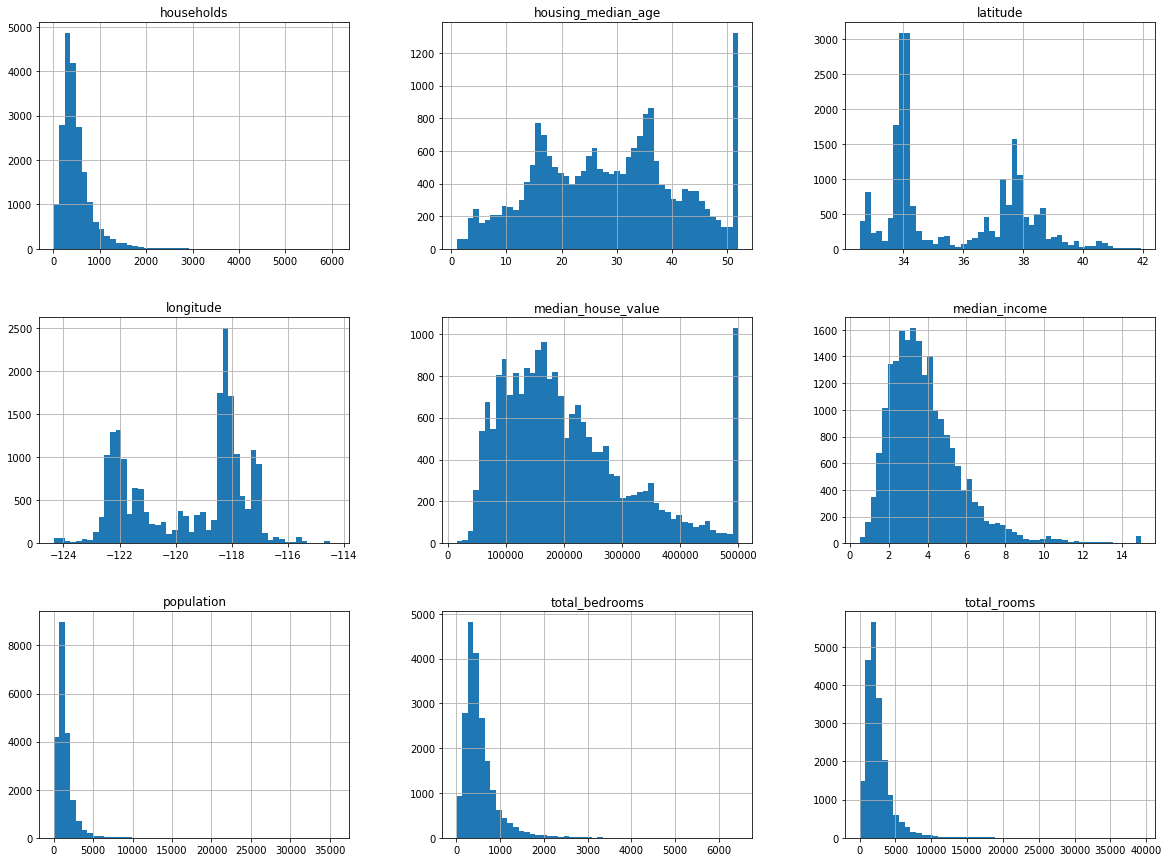

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))

Notice a few things in these histograms:

- These attributes have very different scales. We will discuss this later in this chapter when we explore feature scaling.

- Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

- The housing median age and the median house value were also   
  capped. If they tell you that they need precise predictions
  even beyond $500,000, then you have mainly two options:

  - Collect proper labels for the districts whose labels were capped.
  - Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond
$500,000).

**Create a Test Set**

Creating a test set is theoretically quite simple: just <font color='blue'> pick some instances randomly</font>, typically 20% of the dataset (or less if your dataset is very large), and set them aside:

In [6]:
import numpy as np
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

***
`np.random.permutation`?
***

In [7]:
#np.random.permutation([20,7,32,6])
np.random.permutation(10)

array([6, 3, 0, 2, 5, 9, 7, 8, 1, 4])

***
what is the role of `seed`?
***

In [7]:
np.random.seed(2)
np.random.permutation(10)

array([4, 1, 5, 0, 7, 2, 3, 6, 9, 8])

You can then use this function like this:

In [8]:
train_set, test_set = split_train_test(housing, 0.2)

In [9]:
len(test_set)/len(housing)
#test_set.head()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

A Scikit-Learn functions to split datasets similar to function `split_train_test`: 
***
 `train_test_split`
***

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

`random_state`:  set the random generator seed

**Are purely random sampling methods OK?**

This is generally <font color='blue'> **fine** </font> if your <font color='blue'> **dataset is large enough** </font> (especially relative to the number of attributes), but if it is not, you run the <font color='blue'> **risk** </font> of introducing a significant <font color='blue' > **sampling bias** </font>.

**Example:**

When a survey company decides to call **1000 people** to ask them 
a few questions, they don’t just pick 1000 people randomly in 
a phone book. They try to **ensure** that these 1000 people
are **representative** of the whole population. For example, the US population is composed of **51.3%** female and **48.7%** male, so a well-conducted survey in the US would
try to maintain this ratio in the sample: **513 female and 487 male**. 

This is called <font color='blue'> **stratified sampling**</font>: the population is divided into <font color='blue'> homogeneous subgroups</font> called <font color='blue' > **strata**</font>,
and the right number of instances is sampled from each bstratum to guarantee that the
test set is representative of the overall population.


**For our case:**

Suppose **median income** is a very important attribute to **predict  median housing prices**.

How to ensure that the **test set** is **representative** of the various categories of **incomes** in the whole dataset?

Let’s look at the median income histogram:

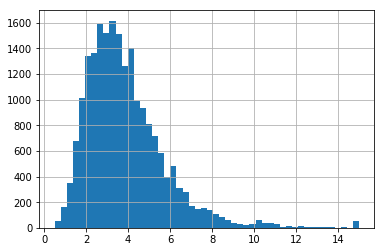

In [11]:
%matplotlib inline
#n, bins, patches =plt.hist(housing['median_income'],bins=50)
housing['median_income'].hist(bins=50)

most median income values are clustered around 1.5 to 6 
(i.e.,$\$15000$–$\$60000$)

It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate
of the stratum’s importance may be biased.

We use `pd.cut()` function to create an income category attribute with 5 categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [15]:
#housing["income_cat"].hist()
#housing["income_cat"]

**stratified sampling based on the income category:**

using Scikit-Learn’s `StratifiedShuffleSplit` class:

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]
        #print(test_index)

a simpler example for StratifiedShuffleSplit

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4],[1,2], [3, 4]])
y = np.array([0, 0, 1 , 1])
#y = np.array([0, 1, 0 , 1])
#y = np.array([1,0,0,1])
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 2] TEST: [3 0]
TRAIN: [0 2] TEST: [1 3]
TRAIN: [0 2] TEST: [3 1]
TRAIN: [2 1] TEST: [3 0]
TRAIN: [3 1] TEST: [0 2]
TRAIN: [1 2] TEST: [3 0]
TRAIN: [1 2] TEST: [0 3]
TRAIN: [0 3] TEST: [2 1]
TRAIN: [0 3] TEST: [1 2]
TRAIN: [1 2] TEST: [3 0]


income category proportions in the test set:

In [15]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

compares the income category proportions in the overall dataset, in
the test set generated with stratified sampling, and in a test set generated using purely
random sampling:

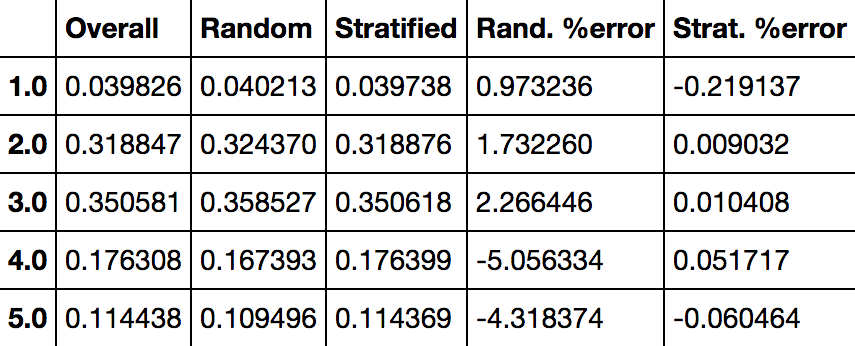

remove the `income_cat` attribute so the data is back to its original
state:

In [16]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

To see details about drop function see:
https://www.w3resource.com/pandas/dataframe/dataframe-drop.php

or see:
pandas-dataframe-drop.ipynb

**Discover and Visualize the Data to Gain Insights**

- Visualizing Geographical Data
- Looking for Correlations
- Experimenting with Attribute Combinations

First, make sure you have put the test set aside and you are only <font color='blue'> exploring the training set. </font>

create a copy so you can play with it without
harming the training set:

In [17]:
housing = strat_train_set.copy()

**Visualizing Geographical Data**

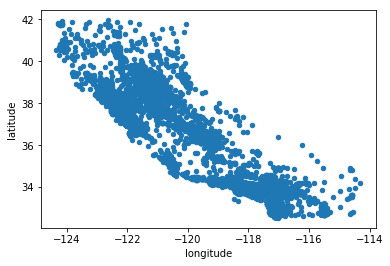

In [18]:
#A geographical scatterplot of the data
housing.plot(kind="scatter", x="longitude", y="latitude")

we use `alpha` parameter to make markers transparent:

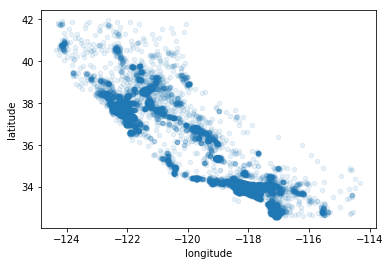

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

you can clearly see the high-density areas, namely the Bay
Area and around Los Angeles and San Diego, plus a long line of fairly high density in
the Central Valley, in particular around Sacramento and Fresno.

look at the housing prices:

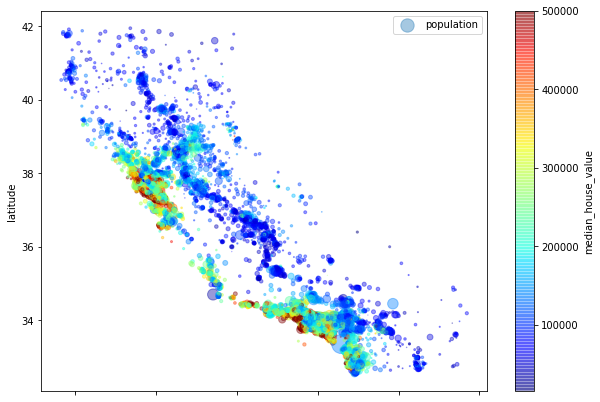

In [20]:
import matplotlib.pyplot as plt
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We
will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

This image tells:

- housing prices are very much related to the **location** (e.g., close to the ocean) and to the **population density**, as you probably knew already.

- It will probably be useful to use a **clustering algorithm** to detect the **main clusters**, and add new features that measure the proximity to the cluster centers. 

- The **ocean proximity attribute** may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

**Looking for Correlations:**


*standard correlation coefficient* or *Pearson correlation coefficient* (also called *Pearson’s r*) between paired data ${\displaystyle \left\{(x_{1},y_{1}),\ldots ,(x_{n},y_{n})\right\}}$ consisting of  ${\displaystyle n}$  pairs:
$$ {\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}$$

Please see wikipedia:
https://en.wikipedia.org/wiki/Pearson_correlation_coefficient



In DataFrame pandas, we can use `corr()` funcation to calculate correlations.

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
#corr_matrix["median_house_value"].sort_values()
#corr_matrix["median_house_value"]
# ascending:  صعودی

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

- The correlation coefficient <font color='blue'> ranges from –1 to 1 </font>. 

- When it is <font color='blue'> close to 1 </font>, it means that there is a strong positive correlation; for example, the median house value tends to go
 up when the median income goes up. 
 
- When the coefficient is <font color='blue'> close to –1 </font>, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north)

- coefficients close to zero mean that there is no linear correlation

**Standard correlation coefficient of various datasets** (source: Wikipedia):

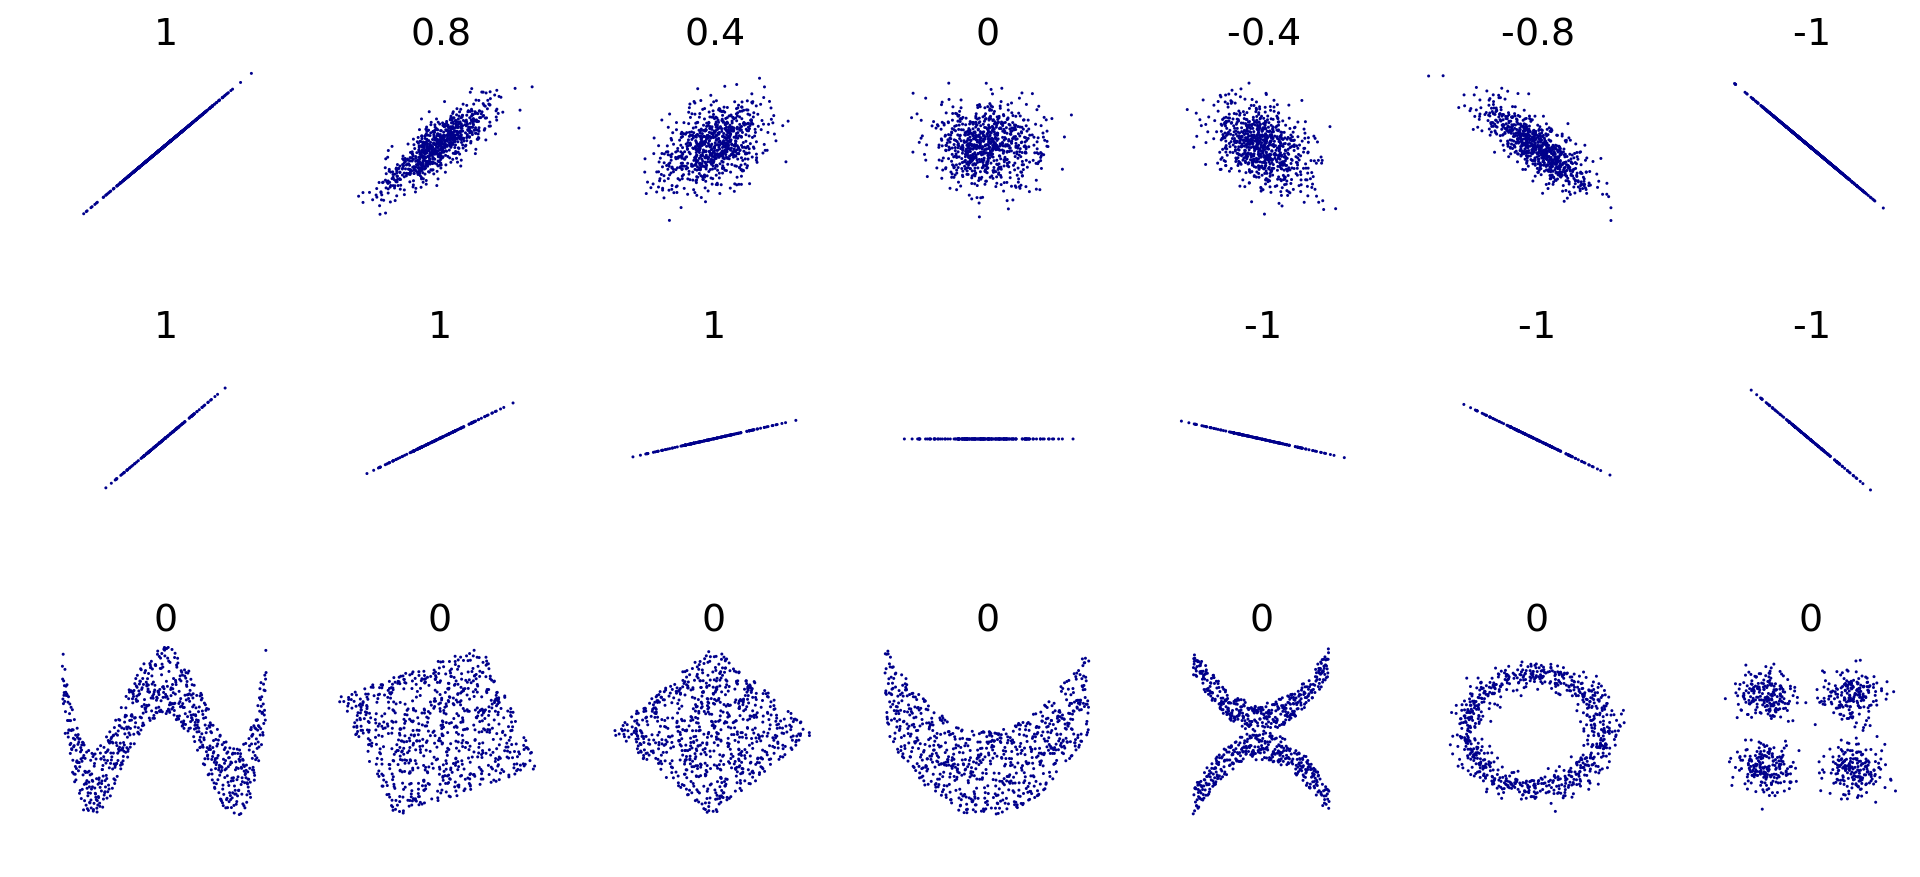

- The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). 

- nonlinear relationships (e.g., “if x is close to zero then y generally goes up”). 

- Note how all the plots of the bottom row have a
 correlation coefficient equal to zero despite the fact that their axes are clearly not independent: these are examples of nonlinear relationships.

- Also, the second row shows examples where the correlation coefficient is equal to 1 or –1; notice that this has nothing to
 do with the slope. For example, your height in inches has a correlation coefficient of 1 with your height in feet or in nanometers.
 

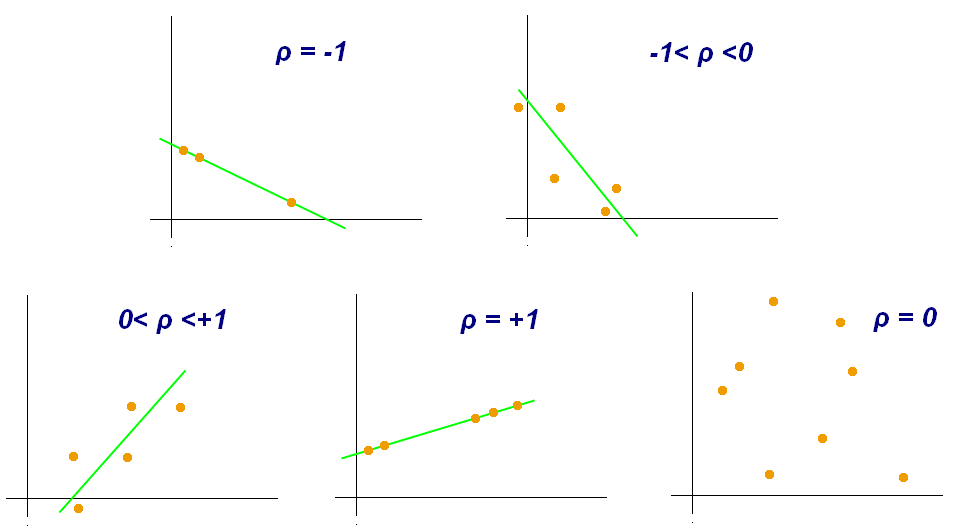
From wikipedia: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

Another way to check for correlation between attributes is to use Pandas’ `scatter_matrix` function:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb21455e2b0>,
      dtype=object)

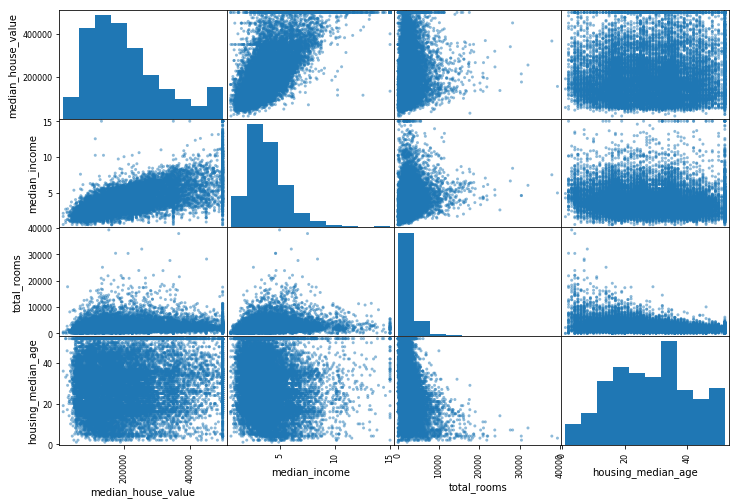

In [23]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The **main diagonal** (top left to bottom right) would be full of straight lines if Pandas plotted each variable against itself, which would not be very useful. So instead Pandas
displays a **histogram** of each attribute

The most promising attribute to predict the median house value is the median
income, so let’s zoom in on their correlation scatterplot:

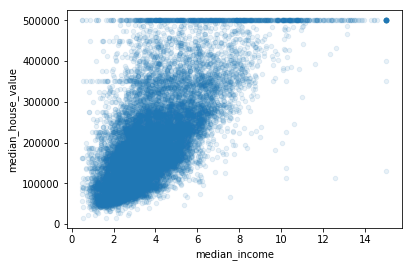

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

- First, correlation is indeed very strong 

- Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $\$$500,000. But this plot reveals other ** less obvious straight lines**: a horizontal line around $\$$450,000,
another around $\$$350,000, perhaps one around $\$$280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

**Experimenting with Attribute Combinations**

For example: 

- the **total number of rooms** in a district is not very useful if you  don’t know how many **households** there are. What you really want is the **number of rooms per household**.

- Similarly, the **total number of bedrooms** by itself is not very useful: you probably want to compare it to the **number of rooms**. 

- And the **population per household** also seems like an interesting attribute combination to look at.

In [25]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

correlation matrix:

In [26]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

- The new `bedrooms_per_room` attribute is much more correlated with
  the median house value than the total number of rooms or bedrooms.   Apparently houses with a lower bedroom/room ratio tend to be more expensive. 
  
- The number of rooms per household (`rooms_per_household`) is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

**Prepare the Data for Machine Learning Algorithms**

- Data Cleaning

- Handling Text and Categorical Attributes

- Feature Scaling

**Caution: before to continue please check the version of Scikit-learn. The version should be $>=$0.2**

In [32]:
import sklearn
sklearn.__version__ >= "0.20"
print(sklearn.__version__)

0.22.1


<font color='blue'> separate the predictors and the labels </font> since we don’t necessarily want to apply the same transformations to the predictors and the target values:

In [27]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

**Data Cleaning**

In [28]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


the `total_bedrooms` attribute has some missing values, so let’s fix this. You have three options:

- Get rid of the corresponding districts.
- Get rid of the whole attribute.
- Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame’s `dropna()`, `drop()`, and `fillna()`
methods:

In [ ]:
housing.dropna(subset=["total_bedrooms"])   # option 1
housing.drop("total_bedrooms", axis=1)      # option 2
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

- The `dropna()` function is used to remove missing values.
  
  Please see: https://www.w3resource.com/pandas/dataframe/dataframe-dropna.php
  
  
- The fillna() function is used to fill NA/NaN values using the specified method <sup>[1](#myfootnote1)</sup>. 

 Please see: https://www.w3resource.com/pandas/series/series-fillna.php
 

<a name="myfootnote1">1</a>: NaN means “not a number” and it means there is a result, but it cannot be represented in the computer. The second, NA , explains that the data is just missing for unknown reasons.

>If you choose option 3, <font color='blue'> you should compute the median value on the training set </font>, and use it to fill the missing values in the training set, but also don’t forget to <font color='blue'> save the median value </font> that you have computed. You will <font color='blue'> need it later to replace missing values
in the test set </font> when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`

-  to suggest that someone or something is the cause of a particular situation, or is responsible for a particular action, especially something bad.

- <font color='blue'> to calculate the value of something which cannot easily be measured in the usual way by giving it a value based on similar things </font>

you need to create a `SimpleImputer` instance, specifying
that you want to replace each attribute’s missing values with the median of that attribute:

In [29]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, we need to create a
copy of the data without the text attribute `ocean_proximity`:

In [30]:
housing_num = housing.drop("ocean_proximity", axis=1)

Now you can fit the `imputer` instance to the training data using the `fit()` method:

In [31]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result
in its `statistics_` instance variable:

In [32]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

We can check it by:

In [33]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now you can use this "trained" imputer to transform the training set by replacing missing values by the learned medians:

In [34]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to
put it back into a Pandas DataFrame, it’s simple:

In [35]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

***
**<center > Scikit-Learn Design </center>**
***

Scikit-Learn’s API (Application programming interface) is remarkably well designed. The main design principles are:

- **Consistency**. All objects share a consistent and simple interface:
  - <font color='red'> *Estimators*</font>. Any object that can estimate some parameters based on a dataset is called an estimator (e.g., an `imputer` is an estimator). The estimation itself is performed by the `fit()` method, and it takes only a dataset as a parameter (or two for supervised learning algorithms; the second dataset contains the labels). Any other parameter needed to guide the estimation process is considered a hyperparameter (such as an `imputer`’s `strategy`), and it must be set as an instance variable (generally via a constructor parameter).
  
  - <font color='red'> *Transformers*</font>. Some estimators (such as an imputer) can also transform a dataset; these are called transformers. Once again, the API is quite simple: the transformation is performed by the `transform()` method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters, as is the case for an imputer. All transformers also have a convenience method called `fit_transform()` that is equivalent to calling `fit()` and then `transform()` (but sometimes
`fit_transform()` is optimized and runs much faster).

  - <font color='red'>*Predictors*</font>. Finally, some estimators are capable of making predictions given a dataset; they are called predictors. For example, the `LinearRegression` model in the previous chapter was a predictor: it predicted life satisfaction given a country’s GDP per capita. A predictor has a `predict()` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a `score()` method that measures the quality of the predictions given a test set (and the corresponding labels in the case of supervised learning algorithms)
  
- **Inspection**. All the estimator’s hyperparameters are accessible directly via public instance variables (e.g., `imputer.strategy`), and all the estimator’s learned
parameters are also accessible via public instance variables with an underscore suffix (e.g., `imputer.statistics_`).

**Handling Text and Categorical Attributes**

In [36]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s `OrdinalEncoder` class.

`sklearn.preprocessing.OrdinalEncoder`:

<font color='blue'> Encode categorical features as an integer array.</font>

The <font color='bule'> input to this transformer should be an array-like of integers or strings</font>, denoting the values taken on by categorical (discrete) features. The features are <font color='blue'> converted to ordinal integers</font>. This results in a single column of integers (0 to n_categories - 1) per feature.

In [37]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]
#ordinal_encoder.fit_transform([['BB'],['BA']])

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

You can get the list of categories using the `categories_` instance variable:

In [38]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g.,
for ordered categories such as "bad", "average", "good", "excellent"), but it is obviously not the case for the `ocean_proximity` column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category
is "<1H OCEAN" (and 0 otherwise), another attribute equal to 1 when the category is "INLAND" (and 0 otherwise), and so on, e.g.:

"<1H OCEAN"$\longrightarrow$ `[1 0 0 0 0]`

"INLAND"$\longrightarrow$ `[0 1 0 0 0]`

...


This is called <font color='blue'> one-hot encoding</font>, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. Scikit-Learn provides a `OneHotEncoder` class to convert categorical values into one-hot vectors:



In [39]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The output is a SciPy sparse matrix, instead of a NumPy array.

**What is Sparse matrix?**

In numerical analysis and scientific computing, a sparse matrix or sparse array is a matrix in which <font color='blue'> most of the elements are zero</font>. (from wikipedia)

For a sparse matrix, we only need to store the location of the non-zero elements:

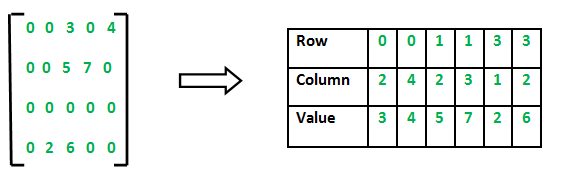

To convert a SciPy sparse matrix, we can use `toarray()` method: 

In [40]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Once again, you can get the list of categories using the encoder’s `categories_`
instance variable:

**Custom Transformers**

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. All you need is to create a class and implement three methods: `fit()` (returning self), `transform()`, and `fit_transform()`.

Example:

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [42]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
17606   -121.89    37.29                 38        1568            351   
18632   -121.93    37.05                 14         679            108   
14650    -117.2    32.77                 31        1952            471   
3230    -119.61    36.31                 25        1847            371   
3555    -118.59    34.23                 17        6592           1525   

      population households median_income ocean_proximity rooms_per_household  \
17606        710        339        2.7042       <1H OCEAN             4.62537   
18632        306        113        6.4214       <1H OCEAN             6.00885   
14650        936        462        2.8621      NEAR OCEAN             4.22511   
3230        1460        353        1.8839          INLAND             5.23229   
3555        4459       1463        3.0347       <1H OCEAN             4.50581   

      population_per_household  
17606                   2.0944  
18632                  2.70796  
14650                  2.02597  
3230                   4.13598  
3555                   3.04785

**Feature Scaling**

One of the <font color='blue'> **most important transformations**</font> you need to apply to your data is <font color='blue'> **feature scaling**</font>. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing
data: the <font color='blue'>total number of rooms</font> ranges from about <font color='blue'> 6 to 39,320</font>, while the median <font color='blue'> incomes</font> only range from <font color='blue'>0 to 15</font>. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: 

- min-max scaling 
- standardization

<font color='blue'> Min-max scaling </font> (many people call this <font color='blue'> normalization</font>): 
    
values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting
the min value and dividing by the max minus the min: 

$$x^{(i)} \longrightarrow \frac{x^{(i)}-\min(\{x^{(i)}\})}{\max(\{x^{(i)}\})-\min(\{x^{(i)}\})} $$

Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a `feature_range` hyperparameter that lets you change the range if you don’t want 0–1 for some reason.

<font color='blue'>Standardization</font>: 

first it subtracts the mean value (so standardized
values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance:

$$x^{(i)} \longrightarrow \frac{x^{(i)}-\langle x^{(i)} \rangle}{\sigma}$$

$\sigma=\sqrt{\frac{1}{N-1} \sum_{i=1}^{N}\left(x^{(i)}-\langle x^{(i)} \rangle \right)^{2}}$



Example:

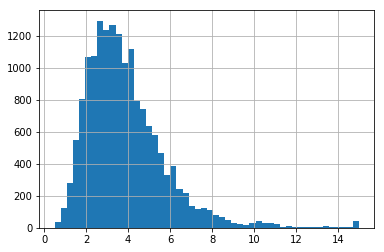

In [43]:
housing["median_income"].hist(bins=50)

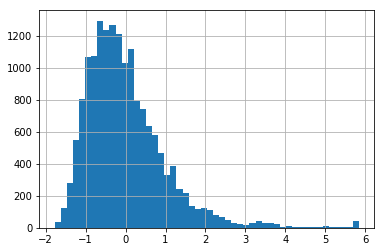

In [44]:
scale_income=(housing["median_income"]-housing["median_income"].mean())/housing["median_income"].std()
scale_income.hist(bins=50)

In [45]:
scale_income.std()

1.0000000000000009

Scikit-Learn provides a transformer called `StandardScaler` for standardization.

The benefit of Standardization:

Unlike min-max scaling, standardization
does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district
had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be
much affected.

**Transformation Pipelines**

there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the `Pipeline` class to help with
such sequences of transformations.

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [47]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

So far, we have handled the <font color='blue'> categorical columns </font> and <font color='blue'> the numerical columns</font> separately.
It would be more convenient to have <font color='blue'> a single transformer</font>  able to <font color='blue'> handle all columns</font>,
applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the `ColumnTransformer` for this purpose:

In [48]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [49]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

**Select and Train a Model**

**Training and Evaluating on the Training Set**

Let’s first train a Linear Regression model:

In [50]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

***
The method that we use is, in fact, multiple linear regression:
***

In [51]:
lin_reg.coef_
#lin_reg.intercept_

array([-55650.4116403 , -56716.45236929,  13732.83841856,  -1933.1277138 ,
         7330.04062103, -45708.26306673,  45455.47519691,  74714.39134154,
         6605.12802802,   1042.95709453,   9249.75886697, -18016.52432168,
       -55219.15208555, 110357.78363967, -22479.84008184, -14642.2671506 ])

Let’s try it out on a few instances from the training set:

In [52]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Let’s measure this regression model’s RMSE on the whole training
set using Scikit-Learn’s `mean_squared_error` function:

In [53]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

most districts’ `median_housing_values` range between $\$120,000$ and $\$265,000$, so a typical prediction error of $\$68,628$ is not very satisfying. This is an example of <font color='blue'> a model **underfitting** the training data</font>.

When this happens it can mean that:
- the <font color='blue'> features</font> do not provide <font color='blue'> enough information</font> to make good   predictions, 
- or that the model is not <font color='blue'> powerful enough</font>.

A more complex: `DecisionTreeRegressor`. This is a powerful model, capable of finding complex nonlinear relationships in the data (see chaper 6).
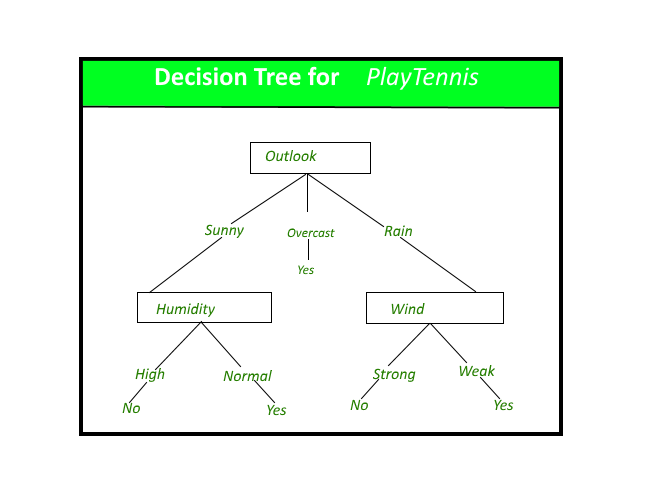
(https://www.geeksforgeeks.org/decision-tree/)

Let's try Decision Tree:

In [54]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now that the model is trained, let’s evaluate it on the training set:

In [55]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

**Wait, what!? No error at all?** Could this model really be absolutely perfect? Of course, it is much more likely that the <font color='blue'>model has badly overfit the data</font>. 

How can you be sure? As we saw earlier, you <font color='blue'> don’t </font> want to <font color='blue'> touch the test set </font> until you are ready to launch a model you are confident about, so you need to <font color='blue'> use part of the training set for training,
and part for model validation.</font>

**Better Evaluation Using Cross-Validation**

You can use the `train_test_split` function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set.

A great alternative is to use Scikit-Learn’s *K-fold cross-validation* feature. The following code randomly <font color='blue'> splits the training set into 10 distinct subsets called **folds**</font>, then <font color='blue'> it trains and evaluates</font> the Decision Tree model <font color='blue'> 10 times</font>, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.
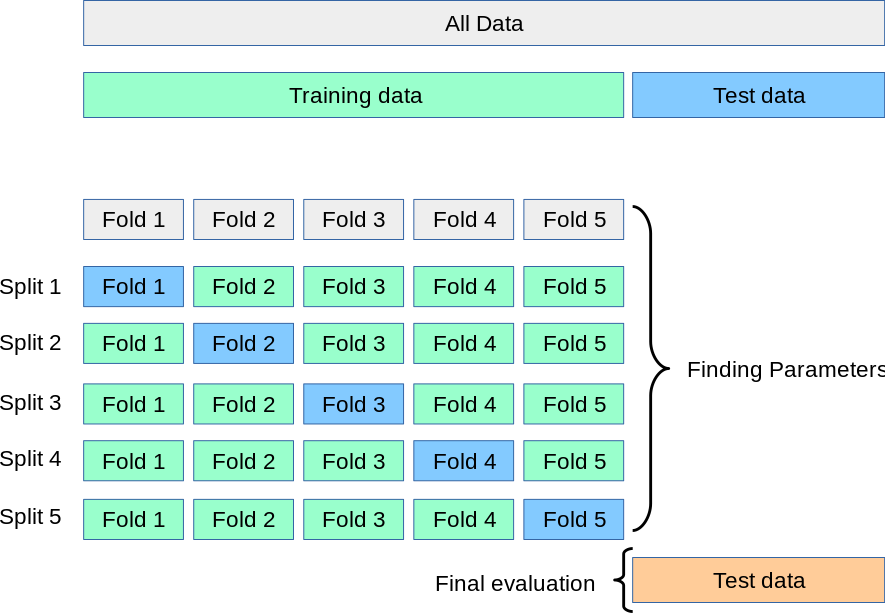
(from:https://scikit-learn.org/stable/modules/cross_validation.html )

In [56]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

>Scikit-Learn’s cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so
the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes `-scores`
before calculating the square root.

Let’s look at the results:

In [57]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean: 70666.74616904806
Standard deviation: 2928.322738055112


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model! 

**Notice:** cross-validation allows you to get not only <font color='blue'> an estimate</font> of the performance of your model, but also <font color='blue'> a measure of how precise this estimate is</font> (i.e., its standard deviation). The Decision Tree has a
score of 71,407$\pm$2,439. 

Let’s compute the same scores for the Linear Regression model 
just to be sure:

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

The Decision Tree model is overfitting so badly that it performs worse
than the Linear Regression model.

Let’s try one last model now: the `RandomForestRegressor` (Chapter 7), Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. <font color='blue'> Building a model on top of many other models is called **Ensemble Learning** </font>, and it is often a great way to push ML algorithms even further.

In [58]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [59]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18680.294240259147

In [60]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49557.6095063  47584.54435547 49605.349788   52325.13724488
 49586.9889247  53154.87424699 48800.48987508 47880.32844243
 52958.68645964 50046.17489414]
Mean: 50150.018373763225
Standard deviation: 1902.0697041387534


Random Forests look very promising. 

However, note that the <font color='blue'> score on the training set </font> is still <font color='blue'> much lower </font> than on the <font color='blue'> validation sets</font>, meaning that the <font color='blue'> model</font> is still <font color='blue'> **overfitting**</font> the training set. 

Possible <font color='blue'> solutions for overfitting</font> are
to <font color='blue'> simplify the model</font>, <font color='blue'> constrain </font> it (i.e., regularize it), or get a lot <font color='blue'> more training data</font>.
However, before you dive much deeper in Random Forests, you should <font color='blue'> try out many other models from various categories of Machine Learning algorithms </font> (several Support
Vector Machines with different kernels, possibly a neural network, etc.), without spending too much time tweaking the hyperparameters. <font color='blue'> **The goal is to shortlist a few (two to five) promising models**.</font>

**Fine-Tune Your Model**

- Grid Search
- Randomized Search
- Ensemble Methods

**Grid Search**

One way to do that would be to <font color='blue'> fiddle</font> with the <font  color='blue' >hyperparameters manually</font>, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.


Instead you should get Scikit-Learn’s `GridSearchCV` to <font color='blue'> search </font> for you. All you need to
do is tell it <font color='blue'> which hyperparameters</font> you want it to experiment with, and <font color='blue'> what values </font> to try out, and it will <font color='blue'> evaluate all the possible combinations of hyperparameter values, using cross-validation</font>. 

For example, the following code searches for the best combination
of hyperparameter values for the `RandomForestRegressor`:

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

This `param_grid` tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of `n_estimators` and `max_features` hyperparameter values specified in the first `dict`
, then try all 2 × 3 = 6 combinations of hyperparameter values in the
second `dict`, but this time with the `bootstrap` hyperparameter set to `False` instead of `True` (which is the default value for this hyperparameter).

All in all, the grid search will explore 12 + 6 = 18 combinations of `RandomForestRegressor` hyperparameter values, and it will train each model five times (since we are using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90
rounds of training!

best combination of parameters:

In [62]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

You can also get the best estimator directly:

In [63]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

evaluation scores:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
#cvres["mean_test_score"]

**Randomized Search**

The <font color='blue'> grid search</font> approach is fine when you are <font color='blue'> exploring</font> relatively <font color='blue'> few combinations</font>,
like in the previous example, but when the hyperparameter search space is large, it is
often preferable to use `RandomizedSearchCV` instead. This class can be used in much
the same way as the GridSearchCV class, but instead of trying out all possible combinations,
it evaluates a given number of random combinations by selecting a random
value for each hyperparameter at every iteration. This approach has two main benefits:

- If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).

- You have more control over the computing budget you want to allocate to hyperparameter search, simply by setting the number of iterations.

**Ensemble Methods**

Another way to fine-tune your system is to try to <font color='blue'> combine the models that perform
best</font>. The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees
they rely on), especially if the individual models make very different types of errors.

**Analyze the Best Models and Their Errors**

You will often gain good <font color='blue'> insights</font> on the problem by <font color='blue'> inspecting the best models</font>. For example, the `RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions:

In [64]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [65]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [66]:
np.sum(feature_importances)

1.0

**Evaluate Your System on the Test Set**

There is nothing special about this process; just get the predictors and the labels from your
test set, run your `full_pipeline` to transform the data (call `transform()`, not `fit_transform()`, you do not want to fit the test set!), and evaluate the final model on the test set:

In [67]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2
final_rmse

47730.22690385927

You might want to have an idea of how precise this estimate is.
For this, you can compute a 95% confidence interval for the generalization error using `scipy.stats.t.interval()`:

In [68]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])